In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings
from pmdarima import auto_arima
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense


In [ ]:
from google.colab import drive

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/Synthetic_data_with_OEE_MME_16_06_24.csv'

In [ ]:
data = pd.read_csv(file_path)

In [ ]:
# Drop the 'Date' column as it's not needed for the model
data = data.drop(columns=['Date'])

In [ ]:
# Split data into features (X) and targets (y)
X = data.drop(columns=['OEE', 'MME'])
y = data[['OEE', 'MME']]

In [ ]:
# Normalize the feature data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize the target data
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


In [ ]:
# Function to create sequences for the GRU model
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 5
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)


In [ ]:
# Define the GRU model with separate outputs for OEE and MME
input_layer = Input(shape=(time_steps, X_train_seq.shape[2]))
gru_layer = GRU(64, return_sequences=True)(input_layer)
gru_layer = GRU(32)(gru_layer)

In [ ]:
# Output layers for OEE and MME
output_oee = Dense(1, name='oee_output')(gru_layer)
output_mme = Dense(1, name='mme_output')(gru_layer)

In [ ]:
model = Model(inputs=input_layer, outputs=[output_oee, output_mme])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
history = model.fit(
    X_train_seq,
    {'oee_output': y_train_seq[:, 0], 'mme_output': y_train_seq[:, 1]},
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
11/11 [==============================] - 7s 108ms/step - loss: 1.9799 - oee_output_loss: 0.9791 - mme_output_loss: 1.0007 - val_loss: 2.1651 - val_oee_output_loss: 1.0484 - val_mme_output_loss: 1.1167
Epoch 2/50
11/11 [==============================] - 0s 13ms/step - loss: 1.8825 - oee_output_loss: 0.9233 - mme_output_loss: 0.9593 - val_loss: 2.1922 - val_oee_output_loss: 1.0791 - val_mme_output_loss: 1.1131
Epoch 3/50
11/11 [==============================] - 0s 14ms/step - loss: 1.8417 - oee_output_loss: 0.9026 - mme_output_loss: 0.9391 - val_loss: 2.2041 - val_oee_output_loss: 1.0961 - val_mme_output_loss: 1.1080
Epoch 4/50
11/11 [==============================] - 0s 12ms/step - loss: 1.8196 - oee_output_loss: 0.8895 - mme_output_loss: 0.9301 - val_loss: 2.2215 - val_oee_output_loss: 1.1077 - val_mme_output_loss: 1.1139
Epoch 5/50
11/11 [==============================] - 0s 14ms/step - loss: 1.7901 - oee_output_loss: 0.8731 - mme_output_loss: 0.9171 - val_loss: 2.2168 - va

In [ ]:
# Predict
y_pred_oee, y_pred_mme = model.predict(X_test_seq)


4/4 [==============================] - 1s 7ms/step


In [ ]:
# Inverse transform the predictions
y_pred_oee_inverse = scaler_y.inverse_transform(np.column_stack([y_pred_oee, np.zeros(y_pred_oee.shape)]))[:, 0]
y_pred_mme_inverse = scaler_y.inverse_transform(np.column_stack([np.zeros(y_pred_mme.shape), y_pred_mme]))[:, 1]

y_test_oee_inverse = scaler_y.inverse_transform(np.column_stack([y_test_seq[:, 0], np.zeros(y_test_seq[:, 0].shape)]))[:, 0]
y_test_mme_inverse = scaler_y.inverse_transform(np.column_stack([np.zeros(y_test_seq[:, 1].shape), y_test_seq[:, 1]]))[:, 1]


In [ ]:
# Calculate evaluation metrics for OEE
rmse_oee = np.sqrt(mean_squared_error(y_test_oee_inverse, y_pred_oee_inverse))
mae_oee = mean_absolute_error(y_test_oee_inverse, y_pred_oee_inverse)
mape_oee = np.mean(np.abs((y_test_oee_inverse - y_pred_oee_inverse) / y_test_oee_inverse)) * 100


In [ ]:
print(f'OEE - RMSE: {rmse_oee}')
print(f'OEE - MAE: {mae_oee}')
print(f'OEE - MAPE: {mape_oee}')

OEE - RMSE: 0.13333134651342196
OEE - MAE: 0.10614760976541937
OEE - MAPE: 16.805164187815944


In [ ]:
# Calculate evaluation metrics for MME
rmse_mme = np.sqrt(mean_squared_error(y_test_mme_inverse, y_pred_mme_inverse))
mae_mme = mean_absolute_error(y_test_mme_inverse, y_pred_mme_inverse)
mape_mme = np.mean(np.abs((y_test_mme_inverse - y_pred_mme_inverse) / y_test_mme_inverse)) * 100


In [ ]:
print(f'MME - RMSE: {rmse_mme}')
print(f'MME - MAE: {mae_mme}')
print(f'MME - MAPE: {mape_mme}')

MME - RMSE: 0.34217547636397855
MME - MAE: 0.28107172178850814
MME - MAPE: 22.59761974595755


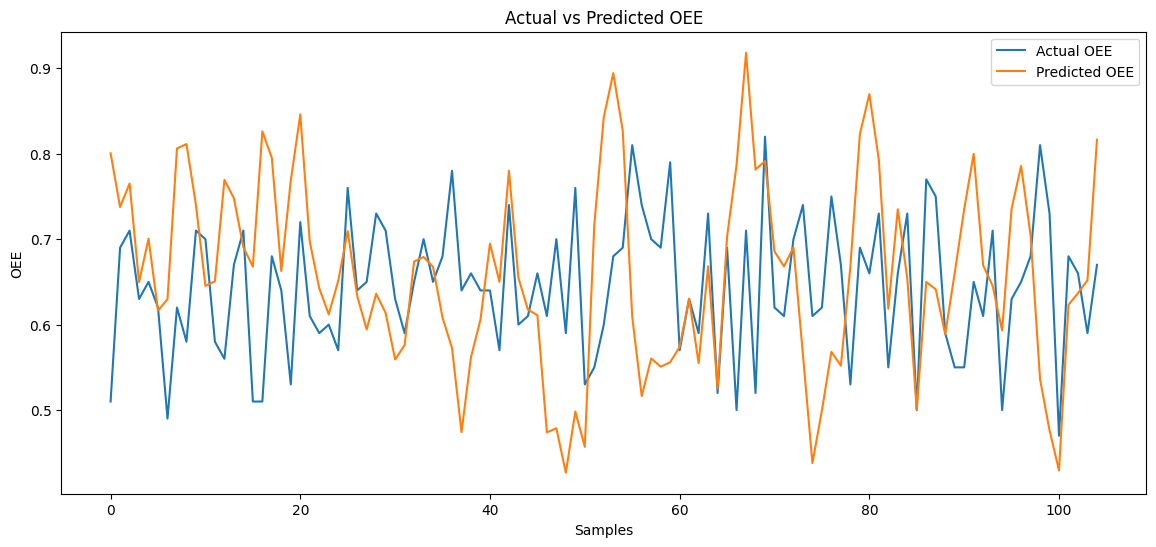

In [ ]:

# Plotting actual vs predicted values for OEE
plt.figure(figsize=(14, 6))
plt.plot(y_test_oee_inverse, label='Actual OEE')
plt.plot(y_pred_oee_inverse, label='Predicted OEE')
plt.title('Actual vs Predicted OEE')
plt.xlabel('Samples')
plt.ylabel('OEE')
plt.legend()
plt.show()


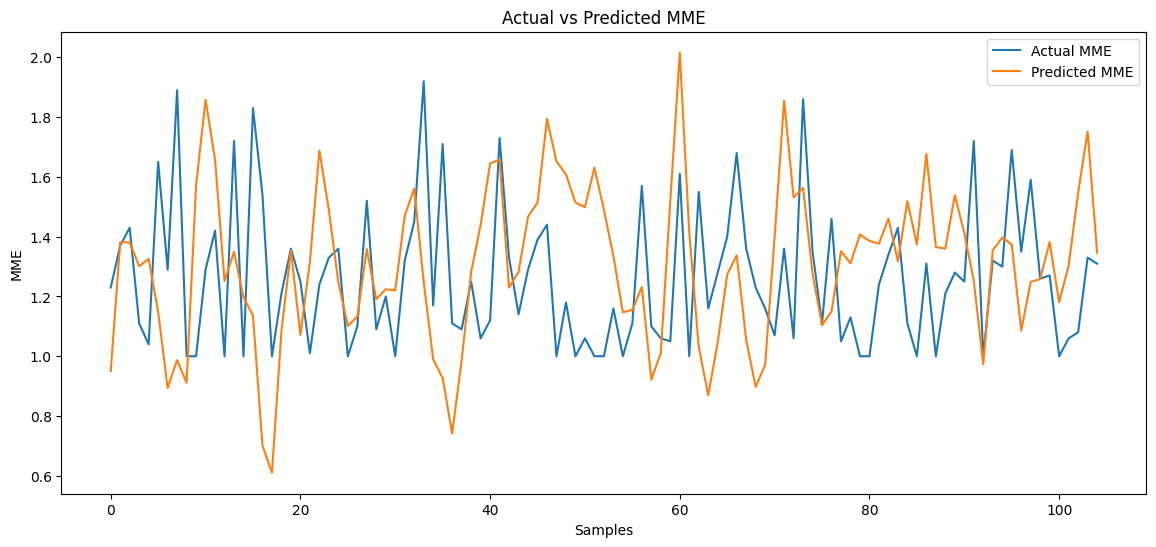

In [ ]:

# Plotting actual vs predicted values for MME
plt.figure(figsize=(14, 6))
plt.plot(y_test_mme_inverse, label='Actual MME')
plt.plot(y_pred_mme_inverse, label='Predicted MME')
plt.title('Actual vs Predicted MME')
plt.xlabel('Samples')
plt.ylabel('MME')
plt.legend()
plt.show()

### **ARIMA MODEL**

In [ ]:
# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [ ]:
# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

# Check stationarity and differencing if necessary
def make_stationary(series):
    check_stationarity(series)
    diff_order = 0
    while adfuller(series)[1] > 0.05:
        series = series.diff().dropna()
        diff_order += 1
    print(f'Series is stationary after differencing {diff_order} times')
    return series, diff_order

MME:
ADF Statistic: -15.562455698362706
p-value: 2.0343735997556423e-28
Series is stationary
Series is stationary after differencing 0 times


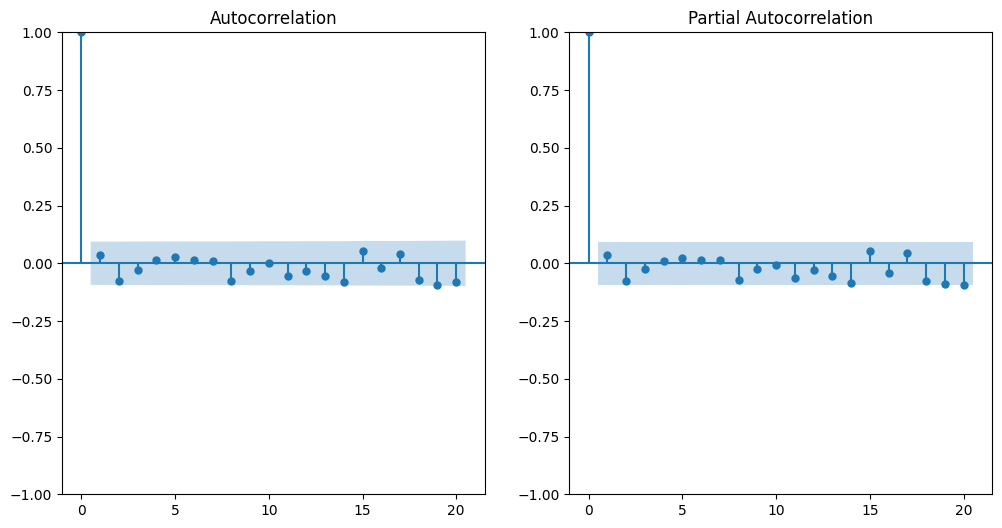

OEE:
ADF Statistic: -21.12852017042351
p-value: 0.0
Series is stationary
Series is stationary after differencing 0 times


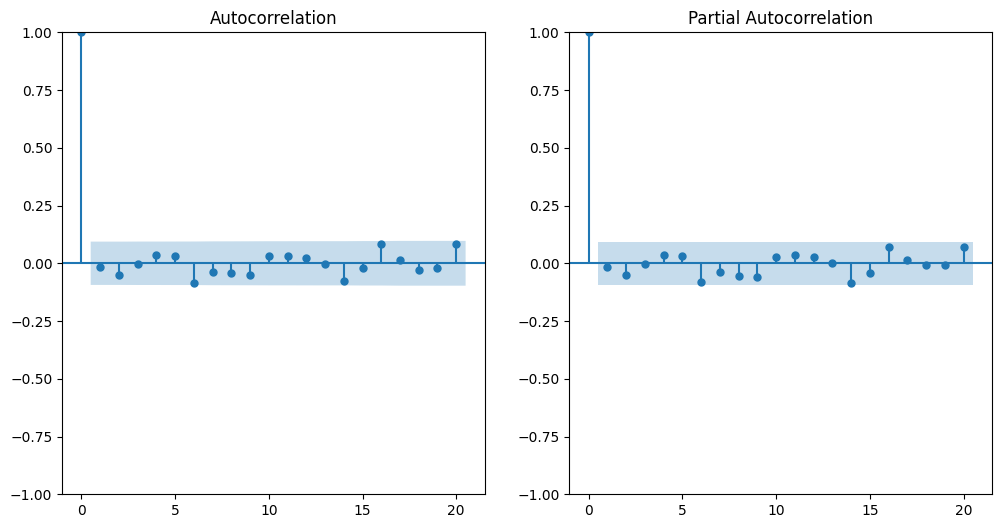

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.63 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1469.515, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=245.141, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1041.805, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=156.680, Time=0.27 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.47 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=1.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=2.47 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-37.300, Time=2.31 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-36.733, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-35.519, Time=0.83 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-35.445, Time=2.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-35.787, Time=3.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-33.523, Time=1.04 sec


In [ ]:
# Function to plot ACF and PACF
def plot_acf_pacf(series):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, ax=plt.gca(), lags=20)
    plt.subplot(122)
    plot_pacf(series, ax=plt.gca(), lags=20)
    plt.show()

# Stationarity and ACF/PACF for MME
print("MME:")
mme_stationary, mme_diff_order = make_stationary(train['MME'])
plot_acf_pacf(mme_stationary)

# Stationarity and ACF/PACF for OEE
print("OEE:")
oee_stationary, oee_diff_order = make_stationary(train['OEE'])
plot_acf_pacf(oee_stationary)

# Auto ARIMA for MME
model_mme = auto_arima(train['MME'], seasonal=False, trace=True)
print(model_mme.summary())

# Auto ARIMA for OEE
model_oee = auto_arima(train['OEE'], seasonal=False, trace=True)
print(model_oee.summary())

In [ ]:
# Function to fit and predict using ARIMA with given orders
def arima_predict(train, test, target, order):
    history = [x for x in train[target]]
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[target].iloc[t])
    return predictions

# Extract best orders from auto_arima
order_mme = model_mme.order
print(order_mme)
order_oee = model_oee.order
print(order_oee)

(2, 0, 0)
(0, 0, 0)


In [ ]:
# Predict MME and OEE using ARIMA
predictions_mme = arima_predict(train, test, 'MME', order_mme)
predictions_oee = arima_predict(train, test, 'OEE', order_oee)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [ ]:
# RMSE_MME using ARIMA
rmse_mme = mean_squared_error(test['MME'], predictions_mme, squared=False)
print("Root Mean Squared Error (RMSE) for MME:", rmse_mme)

# RMSE_OEE using ARIMA
rmse_oee = mean_squared_error(test['OEE'], predictions_oee, squared=False)
print("Root Mean Squared Error (RMSE) for OEE:", rmse_oee)

Root Mean Squared Error (RMSE) for MME: 0.2582011312645194
Root Mean Squared Error (RMSE) for OEE: 0.07497758583922345


In [ ]:
# Custom function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate MAE
mae_MME = mean_absolute_error(test['MME'], predictions_mme)
print("Mean Absolute Error (MAE) for MME:", mae_MME)

# Calculate MAE for OEE
mae_OEE = mean_absolute_error(test['OEE'], predictions_oee)
print("Mean Absolute Error (MAE) for OEE:", mae_OEE)

# Calculate MAPE for MME
mape_MME = mean_absolute_percentage_error(test['MME'], predictions_mme)
print("Mean Absolute Percentage Error (MAPE) for MME:", mape_MME, "%")

# Calculate MAPE for OEE
mape_OEE = mean_absolute_percentage_error(test['OEE'], predictions_oee)
print("Mean Absolute Percentage Error (MAPE) for OEE:", mape_OEE, "%")

Mean Absolute Error (MAE) for MME: 0.21363426977635963
Mean Absolute Error (MAE) for OEE: 0.06078506102710221
Mean Absolute Percentage Error (MAPE) for MME: 16.60104992795543 %
Mean Absolute Percentage Error (MAPE) for OEE: 9.73774534055567 %
